In [18]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import pickle
import gzip
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import np_utils
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.ensemble import RandomForestClassifier
from PIL import Image
import os

#  Definition: Mini-batch Stochastic Gradient Descent

In [62]:
class MiniBatchSGD:
    def __init__(self, _no_of_classes =10,_learning_rate = 0.05, _mini_batch=32):
        self.no_of_classes = _no_of_classes
        self.learning_rate = _learning_rate
        self.mini_batch = _mini_batch
        
    def softmax(self, z):
    
        numerator = np.exp (z)
        demominator =  np.exp(z).sum(axis=0)

        return numerator/demominator
        
    def train_model(self, _TrainingData, _TrainingTarget, _loop_range):
        
        
        no_of_samples = _TrainingData.shape[0]
        
        bias = np.ones([no_of_samples,1])
        
        _TrainingData = np.concatenate((_TrainingData, bias), axis=1)
        
#         print(_TrainingData.shape)
        no_of_features = _TrainingData.shape[1]
        
        
        
        W = np.ones([no_of_features, self.no_of_classes])
        W_NOW = np.transpose(W)

        _TrainingTargetVector =  (np.arange(np.max(_TrainingTarget) + 1) == _TrainingTarget[:, None]).astype(float)

        _loop_range = min(_loop_range, (int) (no_of_samples/self.mini_batch))


        for i in range(_loop_range):

            lowerbound = i*self.mini_batch
            upperbound = min(no_of_samples, (i+1)*self.mini_batch)

            _thisTrainData = _TrainingData[lowerbound:upperbound].T

            z = np.dot(W_NOW, _thisTrainData)
            predicted_values = self.softmax(z).T


            diff = np.subtract(predicted_values, _TrainingTargetVector[lowerbound:upperbound])


            _thisTrainData = _thisTrainData.reshape(no_of_features, self.mini_batch)
            diff = diff.reshape(self.mini_batch, self.no_of_classes)

            Delta_W = np.dot(_thisTrainData, diff)

            W_NOW = W_NOW - (self.learning_rate*Delta_W.T)
        
        self.weights = W_NOW
        
    def get_prediction(self, _data):
        
        no_of_samples = _data.shape[1]
        
        bias = np.ones([1, no_of_samples])
        _data = np.concatenate((_data, bias), axis=0)
        
        
        y_pred   = self.softmax(np.dot(self.weights, _data))
        return y_pred.argmax(axis=0).T
    
    def get_prediction_probability(self, _data):
        
        no_of_samples = _data.shape[1]
        
        bias = np.ones([1, no_of_samples])
        _data = np.concatenate((_data, bias), axis=0)
        
        y_pred   = self.softmax(np.dot(self.weights, _data))
        return y_pred
             
    def get_accuracy(self, _data, _target):
        
        accuracy = 0.0
        counter = 0
        
        pred_data = self.get_prediction(_data)

        for i in range (0,len(pred_data)):
            if(int(pred_data[i]) == _target[i]):
                counter+=1
        accuracy = (float((counter*100))/float(len(pred_data)))
        return accuracy



# Definition: Neural Network

In [3]:
class NeuralNetwork:
    
    def __init__(self, input_size, drop_out, dl_1_nodes, dl_2_nodes, dl_3_nodes, 
                 opt = 'adam', loss_func = 'binary_crossentropy'):
        
        self.model = Sequential()
    
        self.model.add(Dense(dl_1_nodes, input_dim=input_size))
        self.model.add(Activation('relu'))

        self.model.add(Dropout(drop_out))

        self.model.add(Dense(dl_2_nodes))
        self.model.add(Activation('relu'))


        self.model.add(Dropout(drop_out))

        self.model.add(Dense(dl_3_nodes))
        self.model.add(Activation('softmax'))


        self.model.summary()

        self.model.compile(optimizer=opt,
                      loss= loss_func,
                      metrics=['accuracy'])
        
        
    def train_model(self, RawData, RawTarget, ValidationData, ValTargetVector, 
                    num_epochs = 10000, model_batch_size = 128, tb_batch_size = 32, early_patience = 15):
        
        tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)

        earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')

        TargetVector = np_utils.to_categorical(np.array(RawTarget), 10)

        ValTargetVector = np_utils.to_categorical(np.array(ValidationTarget), 10)


        self.history = self.model.fit(RawData
                            , TargetVector
                            , validation_data = (ValidationData, ValTargetVector)
                            , epochs=num_epochs
                            , batch_size=model_batch_size
                            , callbacks = [tensorboard_cb,earlystopping_cb]
                           )
    def plot_history(self):
        %matplotlib inline

        df = pd.DataFrame(self.history.history)
        df.plot(subplots=True, grid=True, figsize=(10,15))
        
    def get_prediction(self, TestingData):
        
        prediction = self.model.predict(TestingData)
        prediction_classes = prediction.argmax(axis=-1)
        return prediction_classes
    
    def get_prediction_probability(self, TestingData):
        
        prediction = self.model.predict(TestingData)
        return prediction
        
    def get_accuracy(self, TestingData, TestingTarget):
        
        prediction_classes = self.get_prediction(TestingData)
        score = accuracy_score(TestingTarget, prediction_classes)
        return score
        

# Definition: Support Vector Machine (SVM)  

In [29]:
class SupportVectorMachine:
    
    def __init__(self, _kernel ='linear', _gamma = 'auto', _C = 1.0):
        
        self.svclassifier = SVC(kernel= _kernel, gamma = _gamma,  C= _C, probability=True) 
        
    def train_model(self, TrainingData, TrainingTarget):
        
        self.svclassifier.fit(TrainingData, TrainingTarget)
        
    def get_prediction(self, TestingData):
        
        y_pred = self.svclassifier.predict(TestingData)
        return y_pred
    
    def get_prediction_probability(self, TestingData):
        
        y_pred = self.svclassifier.predict_proba(TestingData)
        return y_pred
    
    def get_accuracy(self, TestingData, TestingTarget):
        
        y_pred = self.get_prediction(TestingData)
        acc = accuracy_score(TestingTarget, y_pred)
        return acc

# Definition: Random Forest 

In [5]:
class RandomForest:
    
    def __init__(self, _n_estimators=100):
        
        self.clf_rf = RandomForestClassifier(n_estimators=_n_estimators)

    def train_model(self, TrainingData, TrainingTarget):
        
        self.clf_rf.fit(TrainingData, TrainingTarget)
        
    def get_prediction(self, TestingData):
        
        y_pred_rf = self.clf_rf.predict(TestingData)
        return y_pred_rf
    
    def get_prediction_probability(self, TestingData):
        
        y_pred_rf = self.clf_rf.predict_proba(TestingData)
        return y_pred_rf
    
    def get_accuracy(self, TestingData, TestingTarget):
        
        y_pred_rf = self.get_prediction(TestingData)
        acc_rf = accuracy_score(TestingTarget, y_pred_rf)
        return acc_rf

# Pre-process: MNIST DATA

In [6]:
filename = 'mnist.pkl.gz'
f = gzip.open(filename, 'rb')
__training_data, __validation_data, __test_data = pickle.load(f, encoding='latin1')
f.close()

TrainingData = __training_data[0]
TrainingTarget = __training_data[1]

ValidationData = __validation_data[0]
ValidationTarget = __validation_data[1]

TestingData = __test_data[0]
TestingTarget = __test_data[1]


print("=========================")
print("== MNIST Dataset ==")
print("=========================")
print("TrainingData : " + str(TrainingData.shape))
print("TrainingTarget : " + str(TrainingTarget.shape))
print("ValidationData : " + str(ValidationData.shape))
print("ValidationTarget : " + str(ValidationTarget.shape))
print("TestingData : " + str(TestingData.shape))
print("TestingTarget : " + str(TestingTarget.shape))

== MNIST Dataset ==
TrainingData : (50000, 784)
TrainingTarget : (50000,)
ValidationData : (10000, 784)
ValidationTarget : (10000,)
TestingData : (10000, 784)
TestingTarget : (10000,)


# Pre-process: USPS Data

In [19]:
USPSMat  = []
USPSTar  = []
curPath  = 'USPSdata/Numerals'
savedImg = []

for j in range(0,10):
    curFolderPath = curPath + '/' + str(j)
    imgs =  os.listdir(curFolderPath)
    for img in imgs:
        curImg = curFolderPath + '/' + img
        if curImg[-3:] == 'png':
            img = Image.open(curImg,'r')
            img = img.resize((28, 28))
            savedImg = img
            imgdata = (255-np.array(img.getdata()))/255
            USPSMat.append(imgdata)
            USPSTar.append(j)

USPS_Testing_data = np.asarray(USPSMat)
USPS_Testing_target = np.asarray(USPSTar)

print("=========================")
print("==== USPS Dataset ==")
print("=========================")
print("USPS_Testing_data : " + str(USPS_Testing_data.shape))
print("USPS_Testing_target : " + str(USPS_Testing_target.shape))

==== USPS Dataset ==
USPS_Testing_data : (19999, 784)
USPS_Testing_target : (19999,)


# Execution

In [63]:
mini_batch_sgd = MiniBatchSGD(_no_of_classes =10,_learning_rate = 0.05, _mini_batch=50)
mini_batch_sgd.train_model(TrainingData, TrainingTarget, 1000)

# ## Testing Accuracy ##
# acc =mini_batch_sgd.get_accuracy(TestingData.T, TestingTarget)
# print(acc)
# acc =mini_batch_sgd.get_accuracy(ValidationData.T, ValidationTarget)
# print(acc)

# ## Prediction ## 
# pred = mini_batch_sgd.get_prediction(TrainingData[3])
# print(pred)



print("==========================")
print("====== MNIST Dataset =====")
print("==========================")


y_pred = mini_batch_sgd.get_prediction(TestingData.T)
print(confusion_matrix(TestingTarget, y_pred))
print(classification_report(TestingTarget, y_pred))


print("=========================")
print("====== USPS Dataset =====")
print("=========================")


y_pred = mini_batch_sgd.get_prediction(USPS_Testing_data.T)       
print(confusion_matrix(USPS_Testing_target, y_pred))
print(classification_report(USPS_Testing_target, y_pred))

====== MNIST Dataset =====
[[ 970    0    2    2    0    1    1    2    2    0]
 [   0 1113    2    3    0    3    2    1   11    0]
 [  15   14  913   21    7    7    8   17   24    6]
 [   3    1   28  884    0   59    0   13   15    7]
 [   3    8    5    3  882    1    3    7   13   57]
 [  18    4    6   29    5  783    2    9   29    7]
 [  34    3    9    1   18   74  795    4   20    0]
 [   4   10   19    5    3    1    0  965    3   18]
 [  16   16   13   25   12   55    5   15  804   13]
 [  14   11    1    6   27   12    0   43    7  888]]
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       980
           1       0.94      0.98      0.96      1135
           2       0.91      0.88      0.90      1032
           3       0.90      0.88      0.89      1010
           4       0.92      0.90      0.91       982
           5       0.79      0.88      0.83       892
           6       0.97      0.83      0.90       958
         

In [8]:
neural_network = NeuralNetwork(input_size = TrainingData.shape[1], drop_out = 0.2, dl_1_nodes =512, dl_2_nodes =256, dl_3_nodes =10, 
                 opt = 'adam', loss_func = 'categorical_crossentropy')

neural_network.train_model(TrainingData, TrainingTarget, ValidationData, ValidationTarget)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
__________

====== MNIST Dataset =====
[[ 970    1    2    0    1    1    2    1    2    0]
 [   0 1129    1    1    0    1    1    0    2    0]
 [   1    0 1016    1    3    0    0    6    4    1]
 [   0    0    1  991    0    7    0    6    2    3]
 [   0    0    0    1  964    0    1    7    1    8]
 [   2    0    0    4    1  877    4    0    4    0]
 [   3    2    0    1    6    4  941    0    1    0]
 [   1    5    6    1    1    0    0 1001    3   10]
 [   1    0    3    2    0    3    1    4  958    2]
 [   1    4    0    3   12    5    0    1    2  981]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.99      1032
           3       0.99      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.99       958
         

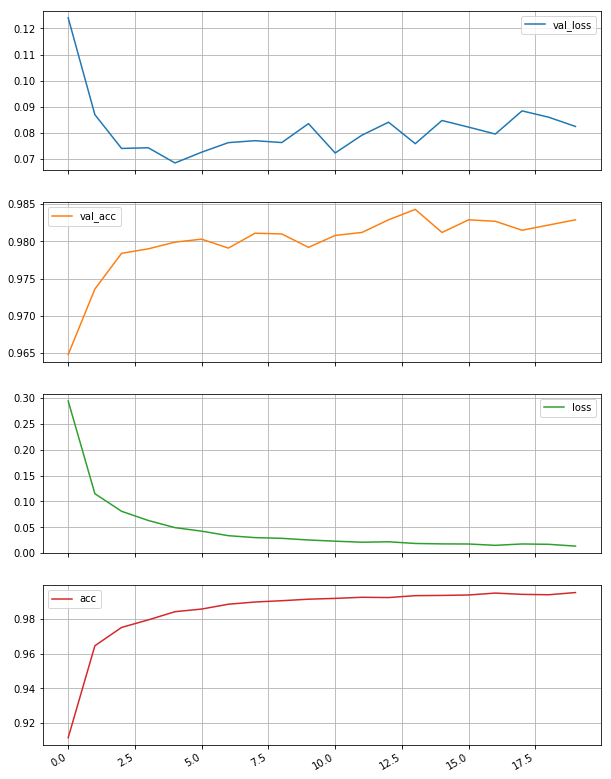

In [40]:
neural_network.plot_history()

print("==========================")
print("====== MNIST Dataset =====")
print("==========================")

# print(neural_network.get_accuracy(TestingData, TestingTarget))
y_pred = neural_network.get_prediction(TestingData)
print(confusion_matrix(TestingTarget, y_pred))
print(classification_report(TestingTarget, y_pred))


print("=========================")
print("====== USPS Dataset =====")
print("=========================")

# print(neural_network.get_accuracy(USPS_Testing_data, USPS_Testing_target))
y_pred = neural_network.get_prediction(USPS_Testing_data)       
print(confusion_matrix(USPS_Testing_target, y_pred))
print(classification_report(USPS_Testing_target, y_pred))

In [10]:
# support_vector_machine = SupportVectorMachine(_kernel ='linear')
# support_vector_machine = SupportVectorMachine(_kernel ='rbf', _gamma = 1.0)
# support_vector_machine = SupportVectorMachine(_kernel ='rbf')
support_vector_machine = SupportVectorMachine(_kernel ='rbf', _gamma = 0.05, _C = 2.0)

support_vector_machine.train_model(TrainingData, TrainingTarget)


In [43]:

print("==========================")
print("====== MNIST Dataset =====")
print("==========================")


# print(support_vector_machine.get_accuracy(TestingData, TestingTarget))

svm_y_pred = support_vector_machine.get_prediction(TestingData)
        
print(confusion_matrix(TestingTarget, svm_y_pred))
print(classification_report(TestingTarget, svm_y_pred))


print("=========================")
print("====== USPS Dataset =====")
print("=========================")

# print(support_vector_machine.get_accuracy(USPS_Testing_data, USPS_Testing_target))

svm_y_pred = support_vector_machine.get_prediction(USPS_Testing_data)
        
print(confusion_matrix(USPS_Testing_target, svm_y_pred))
print(classification_report(USPS_Testing_target, svm_y_pred))

====== MNIST Dataset =====
[[ 974    0    1    0    0    1    1    1    2    0]
 [   0 1128    3    1    0    1    0    1    1    0]
 [   4    0 1015    1    1    0    0    6    5    0]
 [   0    0    1  997    0    3    0    5    4    0]
 [   0    1    3    0  964    0    4    0    2    8]
 [   2    0    1    7    1  872    3    1    4    1]
 [   5    2    0    0    2    3  945    0    1    0]
 [   0    3    9    1    1    0    0 1004    2    8]
 [   2    0    1    6    1    2    0    2  958    2]
 [   4    4    2    8    7    2    0    6    6  970]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
         

In [12]:
rndom_frst = RandomForest(_n_estimators=1000)
rndom_frst.train_model(TrainingData, TrainingTarget)



In [ ]:
# rndom_frst.get_accuracy(TestingData, TestingTarget)

print("==========================")
print("====== MNIST Dataset =====")
print("==========================")


y_pred = rndom_frst.get_prediction(TestingData)
print(confusion_matrix(TestingTarget, y_pred))
print(classification_report(TestingTarget, y_pred))


print("=========================")
print("====== USPS Dataset =====")
print("=========================")


y_pred = rndom_frst.get_prediction(USPS_Testing_data)       
print(confusion_matrix(USPS_Testing_target, y_pred))
print(classification_report(USPS_Testing_target, y_pred))

# Ensemble: Soft Voting

In [42]:
sgd_prediction_prob = mini_batch_sgd.get_prediction_probability(TestingData.T).T
nn_prediction_prob = neural_network.get_prediction_probability(TestingData)
svm_prediction_prob = support_vector_machine.get_prediction_probability(TestingData)
rf_prediction_prob = rndom_frst.get_prediction_probability(TestingData)

# print(sgd_prediction_prob.shape)
# print(nn_prediction_prob.shape)
# print(svm_prediction_prob.shape)
# print(rf_prediction_prob.shape)

sum1 = np.add(nn_prediction_prob,rf_prediction_prob)
sum2 = np.add(sum1,sgd_prediction_prob)
sum3 = np.add(sum2,svm_prediction_prob)
score = accuracy_score(TestingTarget, sum3.argmax(axis=1))

print("==========================")
print("= MNIST Dataset Accuracy =")
print("==========================")
print("Accuracy: " + str(score))



= MNIST Dataset Accuracy =
Accuracy: 0.9804


In [44]:
usps_sgd_prediction_prob = mini_batch_sgd.get_prediction_probability(USPS_Testing_data.T).T
usps_nn_prediction_prob = neural_network.get_prediction_probability(USPS_Testing_data)
usps_svm_prediction_prob = support_vector_machine.get_prediction_probability(USPS_Testing_data)
usps_rf_prediction_prob = rndom_frst.get_prediction_probability(USPS_Testing_data)

# print(usps_sgd_prediction_prob.shape)
# print(usps_nn_prediction_prob.shape)
# print(usps_svm_prediction_prob.shape)
# print(usps_rf_prediction_prob.shape)

sum1 = np.add(usps_nn_prediction_prob,usps_rf_prediction_prob)
sum2 = np.add(sum1,usps_sgd_prediction_prob)
sum3 = np.add(sum2,usps_svm_prediction_prob)
score = accuracy_score(USPS_Testing_target, sum3.argmax(axis=1))

print("==========================")
print("= USPS Dataset Accuracy =")
print("==========================")
print("Accuracy: " + str(score))

= MNIST Dataset Accuracy =
Accuracy: 0.4392719635981799
